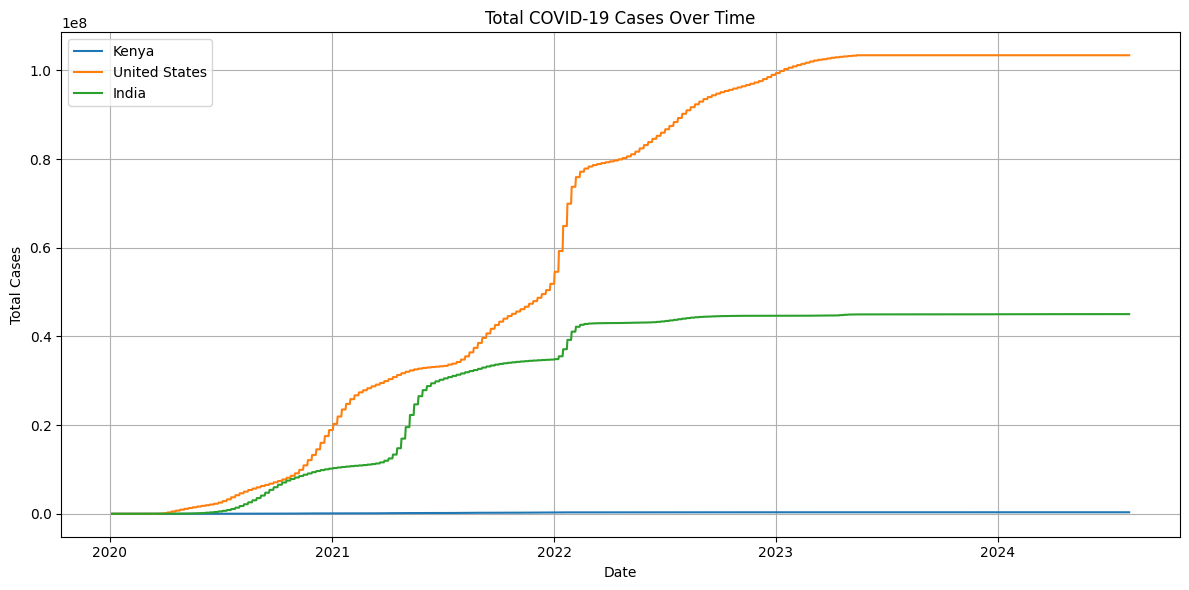

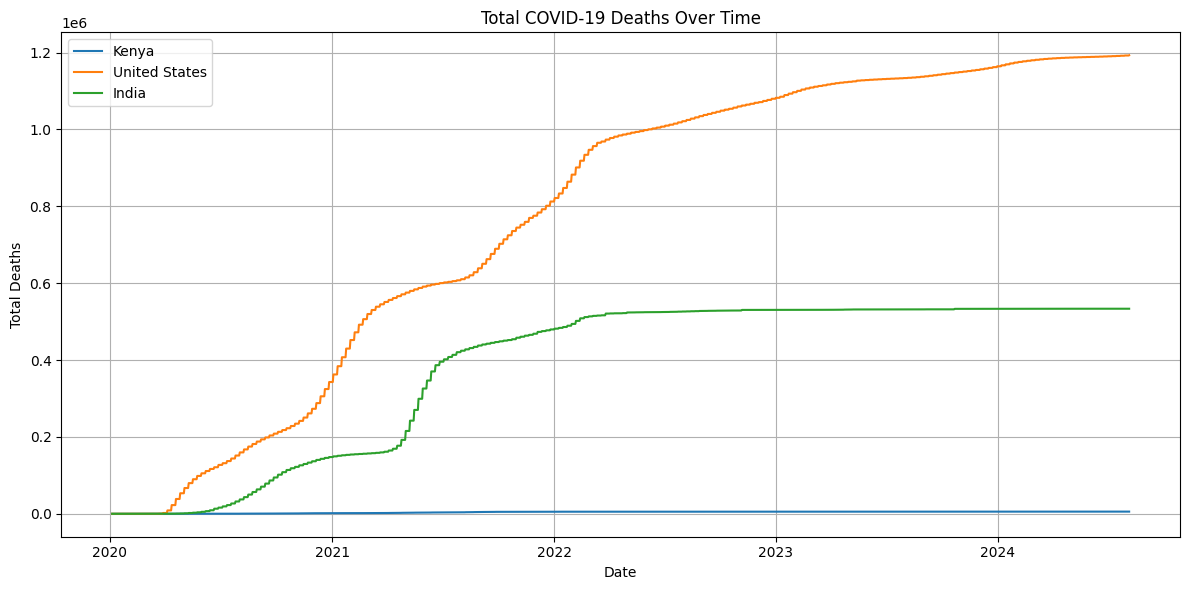

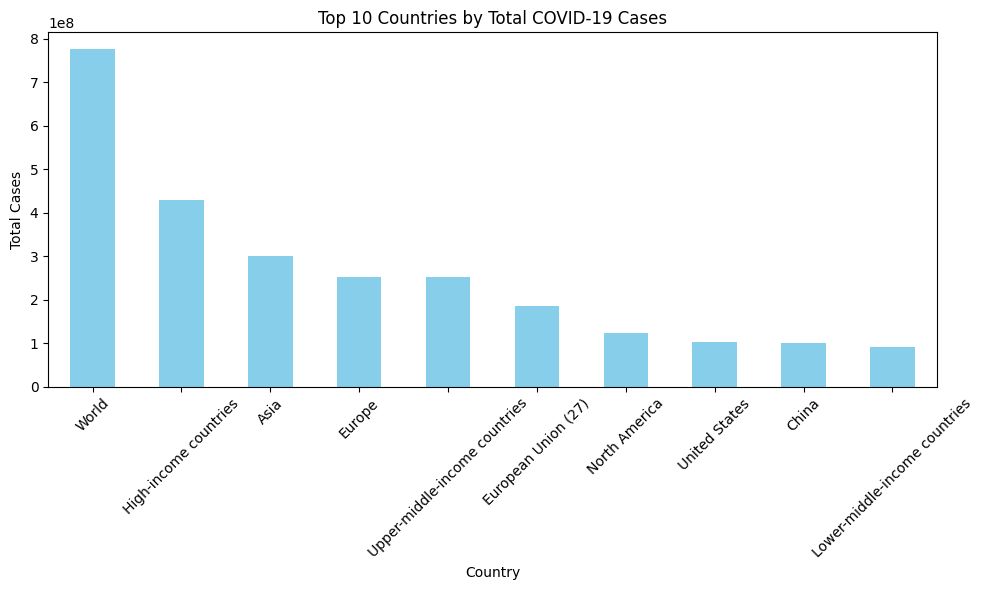

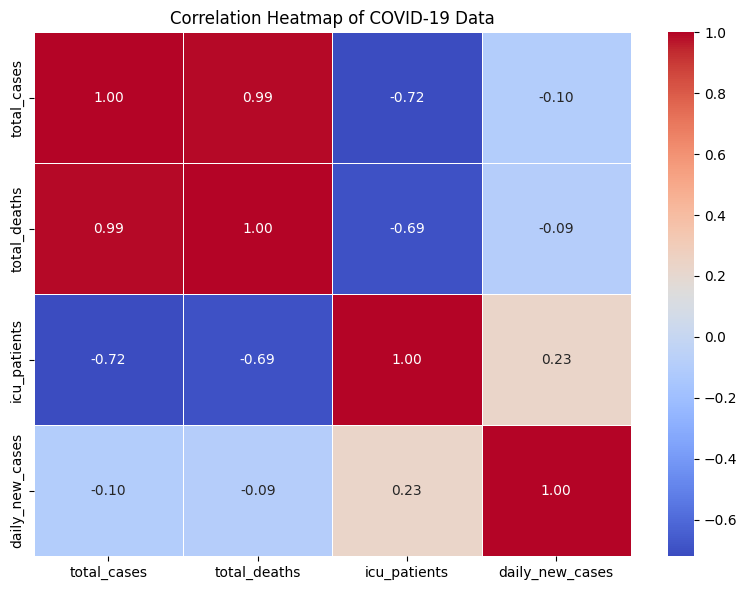

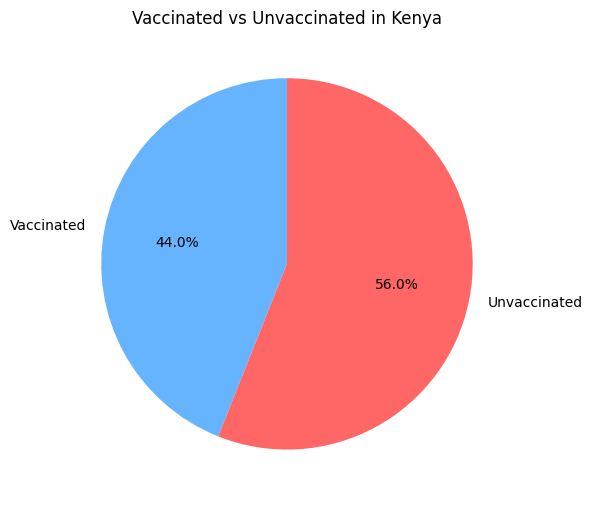

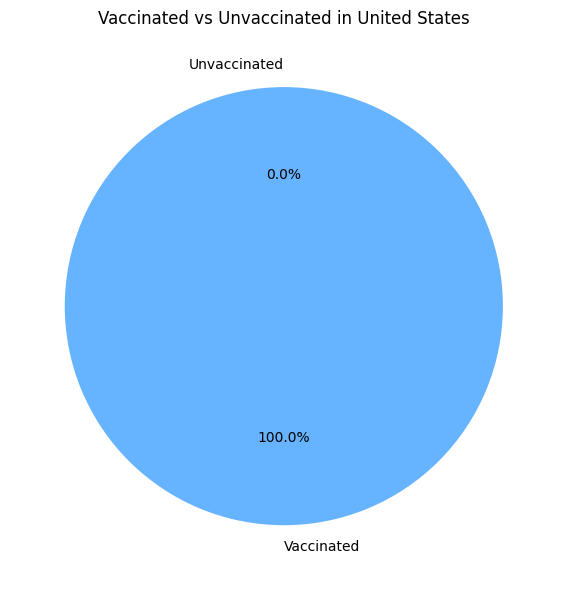

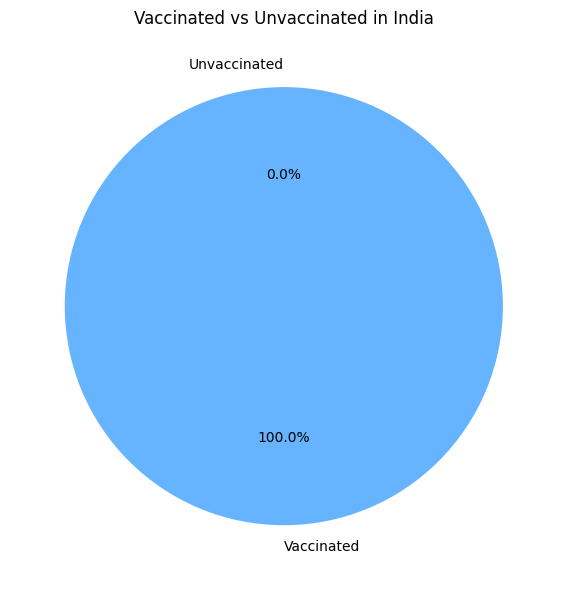

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
df = pd.read_csv('owid-covid-data.csv')

# Filter countries of interest
countries_of_interest = ['Kenya', 'USA', 'India']

# Standardize country names (in case the dataset uses different names like "United States" instead of "USA")
country_name_map = {'USA': 'United States', 'Kenya': 'Kenya', 'India': 'India'}  
countries_of_interest = [country_name_map.get(country, country) for country in countries_of_interest]

# Filter relevant data for countries of interest
countries_of_interest_data = df[df['location'].isin(countries_of_interest)].copy()  # Use .copy() to avoid warning

# Convert 'date' to datetime format using .loc[] to avoid SettingWithCopyWarning
countries_of_interest_data.loc[:, 'date'] = pd.to_datetime(countries_of_interest_data['date'])

# Forward fill missing values in 'icu_patients' using .loc[]
countries_of_interest_data.loc[:, 'icu_patients'] = countries_of_interest_data['icu_patients'].interpolate()

# Sort the data by date and location
countries_data = countries_of_interest_data.sort_values(by=['location', 'date'])

# Calculate daily new cases by subtracting the previous day's total_cases from the current day's total_cases
countries_data['daily_new_cases'] = countries_data.groupby('location')['total_cases'].diff()

# Drop rows with missing daily_new_cases (e.g., first day in the dataset for each country)
countries_data = countries_data.dropna(subset=['daily_new_cases'])

# Calculate death rate (total_deaths / total_cases)
countries_data['death_rate'] = countries_data['total_deaths'] / countries_data['total_cases']

# --- Line Chart: Total Cases Over Time ---
plt.figure(figsize=(12, 6))
for country in countries_of_interest:
    country_data = countries_of_interest_data[countries_of_interest_data['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)

plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Line Chart: Total Deaths Over Time ---
plt.figure(figsize=(12, 6))
for country in countries_of_interest:
    country_data = countries_of_interest_data[countries_of_interest_data['location'] == country]
    plt.plot(country_data['date'], country_data['total_deaths'], label=country)

plt.title('Total COVID-19 Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Bar Chart: Top Countries by Total Cases ---
top_countries = df.groupby('location')['total_cases'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Total COVID-19 Cases')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Heatmap: Correlation Analysis ---
# Filter relevant columns for correlation analysis from the countries_data DataFrame
correlation_data = countries_data[['total_cases', 'total_deaths', 'icu_patients', 'daily_new_cases']].dropna()

# Compute the correlation matrix
corr_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of COVID-19 Data')
plt.tight_layout()
plt.show()

# --- Visualizing Vaccination Progress ---


# Plot pie charts for the vaccinated vs unvaccinated population
latest_data = countries_of_interest_data.groupby('location').last()

# Plot pie charts for the vaccinated vs unvaccinated population
for country in countries_of_interest:
    if country in latest_data.index:  # Check if the country exists in the dataset
        total_population = latest_data.loc[country, 'population']
        vaccinated = latest_data.loc[country, 'total_vaccinations']
        
        # Handle missing or invalid data (e.g., NaN or negative values)
        vaccinated = vaccinated if vaccinated >= 0 else 0
        unvaccinated = total_population - vaccinated
        unvaccinated = unvaccinated if unvaccinated >= 0 else 0

        # Plot the pie chart
        plt.figure(figsize=(6, 6))
        plt.pie([vaccinated, unvaccinated], labels=['Vaccinated', 'Unvaccinated'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
        plt.title(f'Vaccinated vs Unvaccinated in {country}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Data for {country} not found!")
